##### Copyright 2019 The TensorFlow Authors.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow
from tensorflow import keras
import tensorflow as tf
#from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input,Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU
from keras.layers import BatchNormalization,Dropout,Embedding,Activation,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical  

In [ ]:
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile("/content/drive/My Drive/brain.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = True
  
#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed8')
#print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2022-04-21 14:53:33--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 173.194.76.128, 142.251.5.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  44.3MB/s    in 1.9s    

2022-04-21 14:53:35 (44.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.optimizers import RMSprop
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (3, activation='softmax')(x)           
model = Model(pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(lr=0.00003), #0.0001
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy','Precision', 'Recall'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 conv2d_13 (Conv2D)             (None, 16, 16, 48)   12288       ['mixed0[0][0]']                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_15[0][0]']          
                                                                                                  
 batch_normalization_13 (BatchN  (None, 16, 16, 48)  144         ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_16 (BatchN  (None, 16, 16, 96)  288         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/dataset/train"
training_datagen = ImageDataGenerator(rescale = 1./255)
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/dataset/test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
  class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=32
)


Found 2451 images belonging to 3 classes.
Found 613 images belonging to 3 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96 and logs.get('accuracy')>0.975):
      print("\nReached predicted accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 5,
            verbose = 1,
            callbacks = [callbacks]
            )

Epoch 1/5
77/77 [==============================] - 53s 398ms/step - loss: 0.5975 - accuracy: 0.7479 - precision: 0.7957 - recall: 0.7009 - val_loss: 0.9234 - val_accuracy: 0.6721 - val_precision: 0.6772 - val_recall: 0.6672
Epoch 2/5
77/77 [==============================] - 28s 359ms/step - loss: 0.3573 - accuracy: 0.8596 - precision: 0.8747 - recall: 0.8458 - val_loss: 0.4712 - val_accuracy: 0.7977 - val_precision: 0.8027 - val_recall: 0.7830
Epoch 3/5
77/77 [==============================] - 27s 352ms/step - loss: 0.2695 - accuracy: 0.8943 - precision: 0.9010 - recall: 0.8800 - val_loss: 0.2038 - val_accuracy: 0.9201 - val_precision: 0.9288 - val_recall: 0.9152
Epoch 4/5
77/77 [==============================] - 27s 354ms/step - loss: 0.2202 - accuracy: 0.9139 - precision: 0.9202 - recall: 0.9086 - val_loss: 0.1369 - val_accuracy: 0.9478 - val_precision: 0.9488 - val_recall: 0.9380
Epoch 5/5
77/77 [==============================] - 28s 359ms/step - loss: 0.1943 - accuracy: 0.9323 - pr

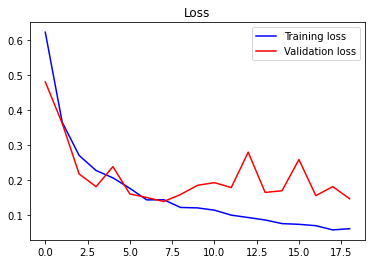

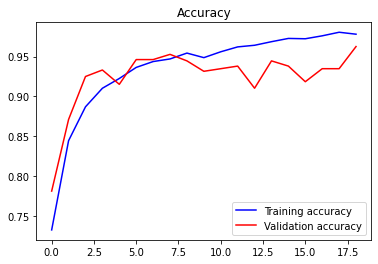

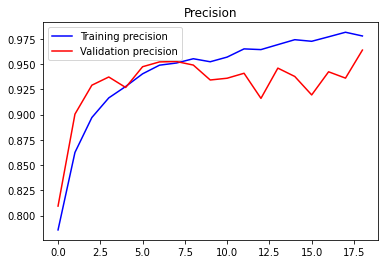

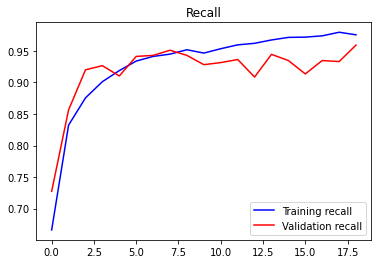

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, precision, 'b', label='Training precision')
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.title('Precision')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, recall, 'b', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Recall')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)